In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 6.4 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont



urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')


__EXTRACK ANNOTATIONS FROM XML FORMAT__

In [3]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/english_setter_119.xml'

In [4]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [5]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [6]:
extract_annotation(xml_files[0])

{'file': 'english_setter_119.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 349, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 298,
   'top': 66,
   'width': 144,
   'height': 117}]}

__DATA VISUALIZATION__

In [8]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 20)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

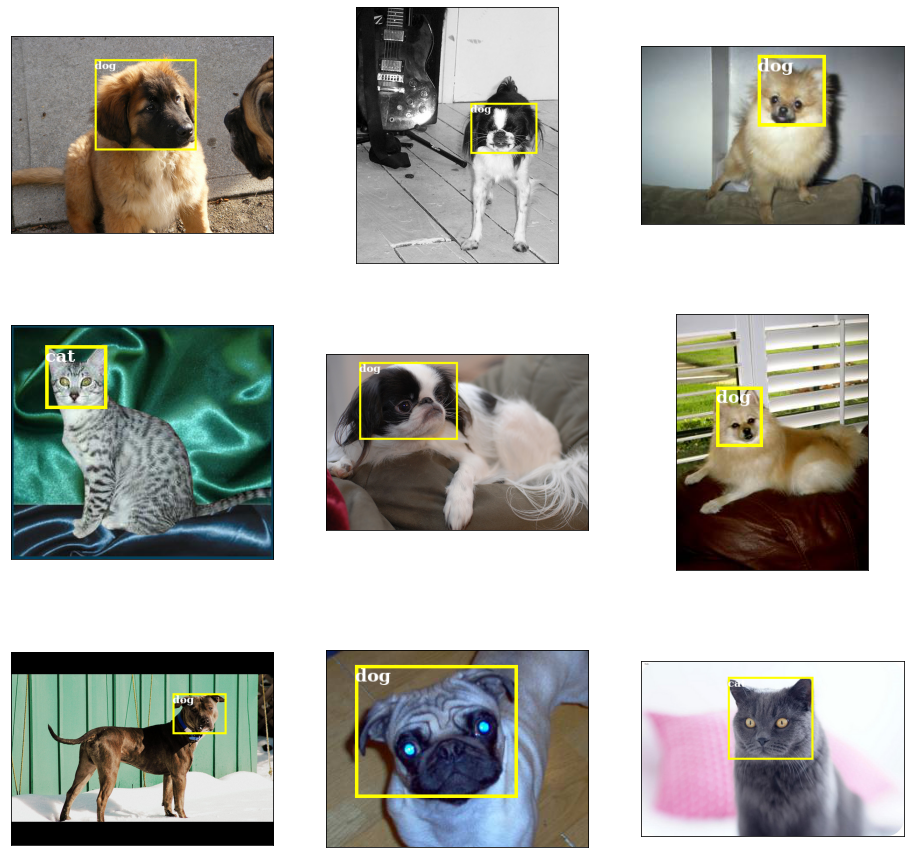

In [9]:
show_random_annotations(plt)

__SAGEMAKER SETUP__

In [10]:
role = sagemaker.get_execution_role()
bucket_name = 'od-imagespets'
training_image = get_image_uri(boto3.Session().region_name, 'object-detection',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


In [11]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

__PREPARING DATA__

In [12]:
for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:01<00:00, 2173.50it/s]


In [13]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [14]:
print(len(train_annots), len(train_images))

2745 2745


In [15]:
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

__UPLOAD DATA TO S3__

In [16]:
%%time
sess = sagemaker.Session()

print('Uploading data..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Uploading data..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 55.2 s, sys: 3.55 s, total: 58.8 s
Wall time: 5min 43s


In [17]:
s3_validation_annotation_path

's3://od-imagespets/validation_annotation'

__SAGEMAKER MODEL__

In [19]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://od-imagespets/output',
    sagemaker_session=sess
)

__HYPERPARAMETER TUNNING__

In [20]:
model.set_hyperparameters(
    base_network='resnet-50',
    num_classes=2,
    use_pretrained_model=1,
    mini_batch_size=16,
    epochs=15,
    learning_rate=0.001,
    lr_scheduler_step='10',
    lr_scheduler_factor=0.1,
    optimizer='sgd',
    momentum=0.9,
    weight_decay=0.0005,
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=512,
    num_training_samples=len(train_annots)
)

__DATA CHANNELS__

In [22]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

In [23]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

__MODEL TRAINING__

In [24]:
model.fit(inputs=data_channels, logs=True)

2021-01-18 20:15:22 Starting - Starting the training job...
2021-01-18 20:15:46 Starting - Launching requested ML instancesProfilerReport-1611000922: InProgress
......
2021-01-18 20:16:47 Starting - Preparing the instances for training.........
2021-01-18 20:18:08 Downloading - Downloading input data......
2021-01-18 20:19:09 Training - Downloading the training image...
2021-01-18 20:19:49 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[01/18/2021 20:19:42 INFO 140251450963776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', 

In [25]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

-----------------!
Model deployed!


In [26]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

941


In [30]:
index = 0

image_path = os.path.join(image_dir, images[index])
#image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b, initial_args={"ContentType": "image/jpeg"})
results = json.loads(results)

preds = results['prediction']

In [31]:
preds

[[0.0,
  0.9464716911315918,
  0.4935493469238281,
  0.04106844961643219,
  0.7338902950286865,
  0.33046072721481323],
 [1.0,
  0.14028333127498627,
  0.12255537509918213,
  0.04294440150260925,
  0.8788479566574097,
  0.8914197683334351],
 [0.0,
  0.08424536883831024,
  0.5323541760444641,
  0.054056569933891296,
  0.6901931166648865,
  0.23117785155773163],
 [1.0,
  0.04390214383602142,
  0.12247797846794128,
  0.34790313243865967,
  0.7234817743301392,
  0.8137155771255493],
 [1.0,
  0.03837239369750023,
  0.5312314629554749,
  0.11124590784311295,
  0.6858890652656555,
  0.29065388441085815],
 [0.0,
  0.027627984061837196,
  0.4300681948661804,
  0.12008411437273026,
  0.694950520992279,
  0.2930949926376343],
 [1.0,
  0.027394386008381844,
  0.39171895384788513,
  0.025564908981323242,
  0.773962140083313,
  0.6843075156211853],
 [1.0,
  0.027268309146165848,
  0.38744962215423584,
  0.34727269411087036,
  0.9256389141082764,
  0.9664553999900818],
 [0.0,
  0.027143342420458794,


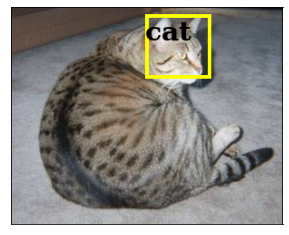

In [32]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 30)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()